In [523]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [566]:
def get_parameters(dataset):
    train = dataset.sample(frac=1)
    y_column = list(train.columns.values)[-1]
    
    X = train.drop(y_column, axis=1)
    Y = train[y_column]

    # One hot encoding for Y
    Y = pd.get_dummies(Y)

    num_classes = Y.shape[1]
    num_features = X.shape[1]
    N = X.shape[0]

    # Weights 
    W = np.random.randint(1, 3, (num_features, num_classes))
    b = np.zeros(num_classes)
    
    return X, Y, W, b, N

In [567]:
def softmax(logits):
    '''
        Computes the softmax function value
    '''
    activation = []#[np.exp(pre_act[i]) / np.sum(np.exp(pre_act[i])) for i in range(0, len(pre_act))]
    for index in range(0, len(logits)):
        exp_sum = 0
        for val in logits[index]:
            exp_sum += np.exp(val)
        activation.append([np.exp(value) / exp_sum for value in logits[index]])
        
    return activation

In [568]:
def compute_pre_act(input_x, weights, bias):
    '''
        Compute pre activation i.e. f = X*W + b
    '''
    
    return np.dot(input_x, weights) + bias

In [569]:
def compute_activation(X, W, b):

    #XT = np.transpose(X)

    # Compute activation in forward propogation
    pre_activation = compute_pre_act(X, W, b)

    p = softmax(pre_activation)
    
    return p

In [570]:
def weights_updation(X, Y, W, N, p, learning):

    # Gradient of loss wrt pre activation Wx + b i.e. p - y.
    grad_loss = np.subtract(p, Y)

    # Gradient for weights = XT * (1/N)grad_loss + learn_rate * W
    XT = np.transpose(X)
    learn_rate = learning

    W_grad = np.dot(XT, np.divide(grad_loss, N)) + np.multiply(W, learn_rate)
    
    # Gradient for bias = 1/N * summation(grad_loss[i]) i.e. add up each column => 2x2 matrix
    b_grad = np.sum(np.subtract(p, Y), axis=0) * (1/N)

    return W_grad, b_grad

In [599]:
def compute_loss(X_values, num_instances, learning_rate, Weights_bias, Y_values):
    '''
        Compute loss = -1/N * (summation(Y x log(p))) + (learning_rate / 2) * (summation((Weights[d, k]) ^ 2)
        x => hadamard product
    '''
    Weights = Weights_bias[:len(Weights_bias) - 1]
    bias = Weights_bias[-1]
    
    post_act = compute_activation(X_values, Weights, bias)
    
    # First part without constant
    log_likelihood = np.sum(np.sum(np.multiply(Y_values, np.log(post_act)), axis=1)) * -(1/num_instances)
        
    # Second part without constant    
    regularizer = np.sum(np.square(Weights)) * (learning_rate/2)
            
    loss = log_likelihood + regularizer
    
    return loss

In [734]:
def gradient_checking(X, Y, N, W, bias, learn_rate, weight_grad, bias_grad):
    '''
        Compute the numerical gradient for each weight and check if difference from analytical is < 1e-4 for all.
    '''
    epsilon = 1e-2
    
    # Form a weight marix with weights + bias (Add bias as last row)
    weights = np.vstack((W, bias))
    # Similarly for gradient
    grad = np.vstack((weight_grad, bias_grad))
    
    multiplier_matrix = np.zeros((weights.shape[0], weights.shape[1]))
    
    error = []
    num_grads = []
    analyt_grads = []
    result = True
    
    # For each weight at a time compute loss with + epsilon and - epsilon
    for row in range(0, weights.shape[0]):
        for col in range(0, weights.shape[1]):
            # Can simply add or subtract matrix with W
            multiplier_matrix[row][col] = epsilon
            
            L_plus = compute_loss(X, N, learn_rate, np.add(weights, multiplier_matrix), Y)
            L_minus = compute_loss(X, N, learn_rate, np.subtract(weights, multiplier_matrix), Y)
            
            numerical_grad = (L_plus - L_minus) / (2 * epsilon)
            analytical_grad = grad[row][col]
            
            num_grads.append(numerical_grad)
            analyt_grads.append(analytical_grad)
            error.append(numerical_grad - analytical_grad)
    
            # Approximation is always off by epsilon ^ 2
            if (numerical_grad - analytical_grad) < 1e-4: # = np.square(epsilon):
                result &= True
            else:
                result &= False
            
            multiplier_matrix[row][col] = 0
            
    print('Numerical gradients : %s' % num_grads)
    print('Analytical gradients : %s' % analyt_grads)
            
    return error, result

In [991]:
def mini_batching(X_set, Y_set, ind, batch):
    '''
        Returns slices of the sets of size batch
    '''
    if (ind + batch - 1) >= len(X_set):
        resX = X_set[ind:]
        resY = Y_set[ind:]
    else:
        resX = X_set[ind:ind + batch]
        resY = Y_set[ind:ind + batch]
        
    # Shuffle subset
    subset = np.hstack((resX, resY))
    subset = pd.DataFrame(subset).sample(frac=1)
    
    y_column_cnt = Y_set.shape[1]
    
    resX, resY = np.hsplit(subset, [y_column_cnt * -1])
        
    return resX, resY

In [1001]:
def training(train_set, W, b, epoch, M, learning_rate):
    '''
       For each epoch train model with Weights and bias as W and b and training set as train_set.
       Return a list of losses for a each batch
    '''
    losses = []
    
    for epoch_count in range(0, epoch):
        
        # We shuffle for each epoch and take weights from previous epoch
        X, Y, throwW, throwb, N = get_parameters(train_set)

        # Mini batch training
        index = 0
        while index < len(X):
            X_train, Y_train = mini_batching(X, Y, index, M)

            p = compute_activation(X_train, W, b)

            # Weights updation
            W_grad, b_grad = weights_updation(X_train, Y_train, W, N, p, learning_rate)

            weight_bias = np.vstack((W, b))
            
            W = W - W_grad
            b = np.array(b - b_grad)
            
            # Compute loss for the batch
            losses.append(compute_loss(X_train, len(X_train), learning_rate, weight_bias, Y_train))
            
            index += M
        
    return W, b, losses

In [617]:
def fit(train_set, epoch, M, learn_rate):
    '''
        Train the model using train_set for number of iterations = epoch with mini batching of batch M
    '''
    X, Y, W, b, N = get_parameters(train_set)

    return training(train_set, W, b, epoch, M, learn_rate)

In [842]:
# Testing for mesh to produce a decision boundary graph
def test_model_mesh(test_set, Weight_Matrix, bias):    
    softmax_act = compute_activation(test_set, Weight_Matrix, bias)
    
    return np.argmax(softmax_act, axis=1)

In [811]:
# Testing
def test_model(test_set, Weight_Matrix, bias):
    #test_set = test_set.sample(frac=1)
    y_column = list(test_set.columns.values)[-1]
    
    X_test = test_set.drop(y_column, axis=1)
    Y_test = test_set[y_column]
    
    softmax_act = compute_activation(X_test, Weight_Matrix, bias)
    
    #return np.argmax(softmax_act, axis=1)
    return np.mean(Y_test == np.argmax(softmax_act, axis=1))

In [867]:
# 1a
dataset = pd.read_csv('xor.dat', header = None)

In [868]:
X, Y, W, b, N = get_parameters(dataset)
p = compute_activation(X, W, b)

W_grad, b_grad = weights_updation(X, Y, W, N, p, 0.001)

In [869]:
e, result = gradient_checking(X, Y, N, W, b, learn_rate, W_grad, b_grad)
print('Gradient check : %s' % result)

Numerical gradients : [-0.056764266086123394, 0.058764266086125394, -0.11452853217224779, 0.11752853217225079, -0.11552853217225434, 0.11552853217224879]
Analytical gradients : [-0.05676464465750122, 0.0587646446575012, -0.11452928931500245, 0.11752928931500242, -0.11552928931500245, 0.11552928931500242]
Gradient check : True


In [740]:
print('Difference : %s' % e)

Difference : [-3.785713813542202e-07, 3.7857137227814697e-07, -7.571427516339657e-07, 7.571427546593235e-07, -7.571427536323672e-07, 7.571427481090076e-07]


In [917]:
W, b, losses = fit(dataset, 1000, dataset.shape[0], 0.001)
test_model(dataset, W, b)

0.5

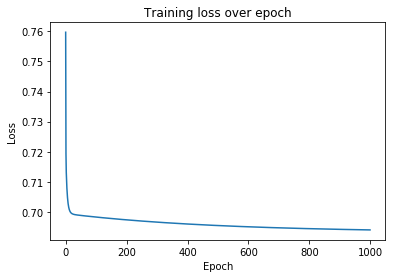

In [872]:
plt.title('Training loss over epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(losses)

In [780]:
X, Y, throw1, throw2, throw3 = get_parameters(dataset_spiral)

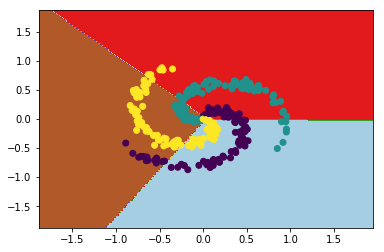

In [996]:
#def 
#C = 1.0

X, Y, throw1, throw2, throw3 = get_parameters(dataset_spiral)
X = X.values
Y = Y.values
#W, b, losses = fit(dataset_spiral, 200, 32, 0.0001)

h = .02  # Step size for mesh values
# Mesh with points for prediction to form decision boundaries
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

XX, YY = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

X = pd.DataFrame(X)
Y = np.argmax(Y, axis=1)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
Prediction = test_model_mesh(pd.DataFrame(np.c_[XX.ravel(), YY.ravel()]), W, b)

# Put the result into a color plot
Prediction = Prediction.reshape(XX.shape)
plt.contourf(XX, YY, Prediction, cmap=plt.cm.Paired)
plt.scatter(X[0], X[1], c=Y)


In [793]:
kk = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()])

In [795]:
ky = pd.DataFrame(Y)

In [796]:
kk.conc

,0,1,2
0,1,0,0
1,0,1,0
2,1,0,0
3,0,0,1
4,0,0,1


In [1002]:
# 1b
dataset_spiral = pd.read_csv('spiral_train.dat', header=None)

In [985]:
X, Y, throw1, throw2, throw3 = get_parameters(dataset_spiral)
setX, setY = mini_batching(X, Y, 0, 15)

In [992]:
Y.shape[1]

3

In [1021]:
W, b, losses = fit(dataset_spiral, 200, 64, 0.0001)

In [1022]:
# We test on the training set so did not split
test_model(dataset_spiral, W, b)

0.49

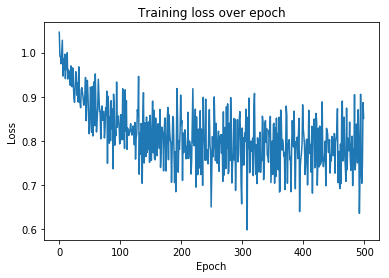

In [1023]:
plt.title('Training loss over epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(losses)

In [1016]:
def validation_loss(validation_set, W, b, learning_rate, epoch):
    # Passing the whole set size as batch size means no mini batching is done
    W, b, losses = fit(validation_set, epoch, validation_set.shape[0], 0.001)
    plt.plot(losses)

In [1012]:
# 1c
dataset_iris = pd.read_csv('iris_train.dat', header = None)

In [1028]:
# Training
W, b, losses = fit(dataset_iris, 100, dataset_iris.shape[0], 0.0001)

In [1029]:
# Test on the validation set
test_model(validation_iris, W, b)

0.65

In [1030]:
# Test on the training set
test_model(dataset_iris, W, b)

0.6727272727272727

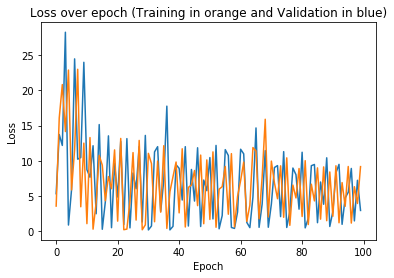

In [1031]:
plt.title('Loss over epoch (Training in orange and Validation in blue)')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# For validation set we calculate losses for each epoch
validation_loss(validation_iris, W, b, 0.0001, 100)
# For training set we calculate losses for each epoch
validation_loss(dataset_iris, W, b, 0.001, 100)

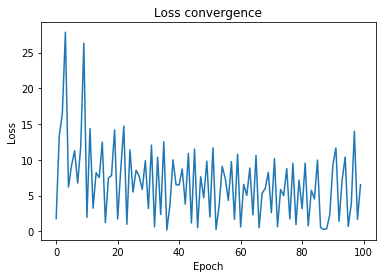

In [1032]:
plt.title('Loss convergence')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(losses)

In [ ]:
e, result = gradient_checking(W_grad)
result

In [ ]:
# Gradient of loss wrt pre activation Wx + b.
grad_loss = np.subtract(p, Y)

# Gradient for weights = XT * (1/N)grad_loss + learn_rate * W
XT = np.transpose(X)
learn_rate = 0.001

W_grad = np.dot(XT, np.divide(grad_loss, N)) + np.multiply(W, learn_rate)

W_grad

In [ ]:
epoch = 100

X, Y, W, b, N, num_classes, num_weights = get_parameters(dataset_spiral)

for epoch_count in range(0, epoch):

    # We shuffle for each epoch and take weights from previous epoches
    X, Y, throwW, throwb, thrownum1, thrownum2, thrownum3 = get_parameters(dataset_spiral)
    
    p = compute_activation(X, W, b)

    # Weights updation
    W_grad, b_grad = weights_updation(X, Y, W, N, p, 0.001)

    W = W - W_grad
    b = np.array(b - b_grad)